# Variational Autoencoder (VAE) sobre MNIST

Este notebook implementa un VAE sencillo, mostrando codificación probabilística, reparametrización y generación desde el espacio latente.

## 1. Instalación
```python
!pip install torch torchvision matplotlib --quiet
```

In [1]:
!pip install torch torchvision matplotlib --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Carga de datos MNIST

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

# Better preprocessing with normalization
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
# ])

train_ds = datasets.MNIST(root='.', train=True, download=True, transform=transform)
dl = DataLoader(train_ds, batch_size=128, shuffle=True)
print(f'Train samples: {len(train_ds)}')

Train samples: 60000


## 3. Definición del modelo VAE

In [3]:
import torch.nn as nn
import torch

class VAE(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 400),
            nn.ReLU()
        )
        self.mu     = nn.Linear(400, z_dim)
        self.logvar = nn.Linear(400, z_dim)
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h      = self.enc(x)
        mu     = self.mu(h)
        logvar = self.logvar(h)
        z      = self.reparam(mu, logvar)
        recon  = self.dec(z)
        return recon, mu, logvar

class ImprovedVAE(nn.Module):
    def __init__(self, z_dim=2):  
        super().__init__()
        # Reduced size encoder
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),  # Reduced from 512
            nn.ReLU(),
            nn.Linear(256, 128),  # Reduced intermediate layer
            nn.ReLU()
        )
        self.mu = nn.Linear(128, z_dim)
        self.logvar = nn.Linear(128, z_dim)
        
        # Reduced size decoder
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),  # Reduced from 512
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparam(mu, logvar)
        recon = self.dec(z)
        return recon, mu, logvar

# Prueba de instancia
model = VAE(z_dim=2)
print(model)

VAE(
  (enc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=400, bias=True)
    (2): ReLU()
  )
  (mu): Linear(in_features=400, out_features=2, bias=True)
  (logvar): Linear(in_features=400, out_features=2, bias=True)
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


## 4. Función de pérdida

In [4]:
import torch.nn.functional as F

def loss_fn(recon, x, mu, logvar, beta=0.5):
    recon_loss = F.binary_cross_entropy(recon, x.view(-1, 784), reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl

# def loss_fn(recon, x, mu, logvar, beta=0.5):
#     recon_loss = F.mse_loss(recon, x.view(-1, 784), reduction='sum')
#     kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + beta * kl, recon_loss, kl

## 5. Entrenamiento rápido (1–2 épocas)

In [5]:
import torch.optim as optim

# Hiperparámetros mejorados
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedVAE(z_dim=2).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)

epochs = 20
best_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in dl:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss, rL, kL = loss_fn(recon, x, mu, logvar, beta=0.5)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(dl)
    scheduler.step(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.2f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

Epoch 1, Loss: 24248.50
Epoch 2, Loss: 20606.67
Epoch 3, Loss: 19880.44
Epoch 4, Loss: 19429.05
Epoch 5, Loss: 19085.82
Epoch 6, Loss: 18825.75
Epoch 7, Loss: 18637.42
Epoch 8, Loss: 18498.13
Epoch 9, Loss: 18296.75
Epoch 10, Loss: 18176.51
Epoch 11, Loss: 18077.27
Epoch 12, Loss: 17976.93
Epoch 13, Loss: 17917.89
Epoch 14, Loss: 17847.11
Epoch 15, Loss: 17776.18
Epoch 16, Loss: 17726.26
Epoch 17, Loss: 17657.20
Epoch 18, Loss: 17657.33
Epoch 19, Loss: 17571.27
Epoch 20, Loss: 17527.09


## 6. Visualización del espacio latente

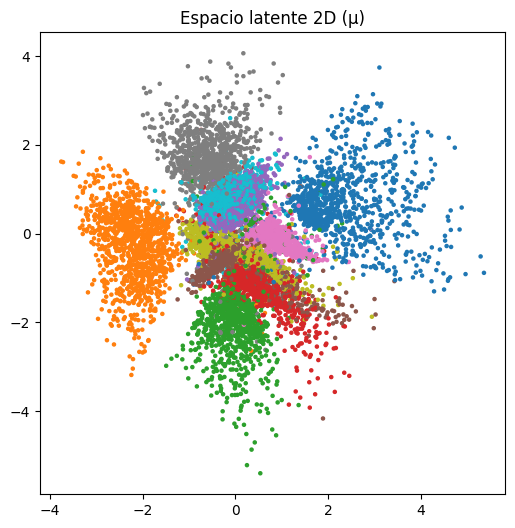

In [6]:
import matplotlib.pyplot as plt
from torchvision import datasets

# Load test set
test_ds = datasets.MNIST(root='.', train=False, download=True, transform=transform)
dl_t = DataLoader(test_ds, batch_size=1024)

model.eval()
mus, labels = [], []
with torch.no_grad():
    for x, y in dl_t:
        x = x.to(device)
        _, mu, _ = model(x)
        mus.append(mu.cpu())
        labels.append(y)
mus = torch.cat(mus)
labels = torch.cat(labels)

plt.figure(figsize=(6,6))
plt.scatter(mus[:,0], mus[:,1], c=labels, cmap='tab10', s=5)
plt.title('Espacio latente 2D (μ)')
plt.show()

## 7. Generación desde rejilla

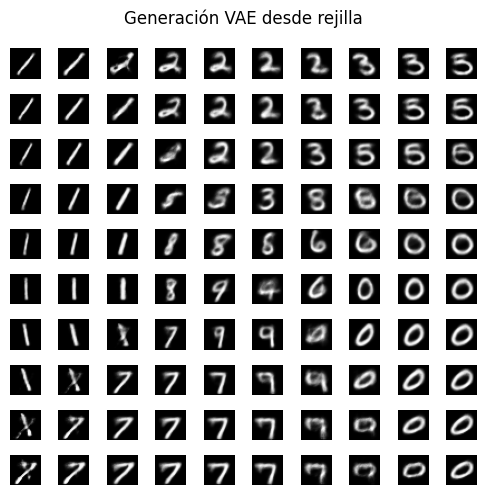

In [13]:
import numpy as np

grid_x = np.linspace(-3, 3, 10)
grid_y = np.linspace(-3, 3, 10)
imgs = []

for yi in grid_y:
    for xi in grid_x:
        z = torch.tensor([[xi, yi]], device=device).float()
        recon = model.dec(z).view(28, 28).cpu().detach().numpy()
        imgs.append(recon)

fig, axs = plt.subplots(10, 10, figsize=(5,5), tight_layout=True)
for ax, img in zip(axs.flatten(), imgs):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generación VAE desde rejilla')
plt.show()